# Monte Carlo Portfolio Risk Simulation

## Introduction
This project analyzes the risk of a multi-asset equity portfolio (AAPL, MSFT, SPY). 

**Why use Monte Carlo simulation?**
Predicting the exact future of the stock market is impossible. However, by simulating thousands of different potential market scenarios based on historical data, we can model the *probability* of different outcomes. This allows us to estimate the potential downside risk during a bad year.

**Goal:** Estimate potential losses over a 1-year horizon using **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)**.

In [ ]:
# Imports & Configuration 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import custom modules from the src/ directory
from src.data_loader import load_price_data, get_return_stats
from src.simulation import simulate_portfolio_paths
from src.risk_metrics import calculate_metrics
from src.visualization import plot_simulation

# Set random seed for reproducibility
np.random.seed(42)

# Simulation Parameters
INITIAL_PORTFOLIO = 100_000   # Starting Capital ($)
TIME_HORIZON = 252            # 1 Trading Year
N_SIMS = 5000                 # Number of simulated paths
DATA_PATH = 'data/prices.csv'

## 1. Data Loading & Preparation
First, I load historical daily prices for the assets to understand their behavior. To simulate future performance, I calculate two key statistics:

* **Mean Returns:** The average daily growth rate for each asset.
* **Covariance:** A measure of volatility and correlation (how the assets move in relation to each other).

In [2]:
# Load data
prices = load_price_data(DATA_PATH)

# Calculate statistics
mu, cov_matrix = get_return_stats(prices)

# Define Weights (Equal weighting: 33% each)
num_assets = len(mu)
weights = np.ones(num_assets) / num_assets

# Display data preview
print("Asset Prices Head:")
display(prices.head())

print(f"\nAssets: {list(prices.columns)}")
print(f"Annualized Volatilities: {np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)}")

Asset Prices Head:


,AAPL,NVDA,INTC
Date,,,
2025-01-02,243.582,138.31,20.22
2025-01-03,243.093,144.47,20.56
2025-01-06,244.731,149.43,19.87
2025-01-07,241.944,140.14,20.01
2025-01-08,242.433,140.11,19.88



Assets: ['AAPL', 'NVDA', 'INTC']
Annualized Volatilities: [0.32141318 0.49841682 0.62342251]


## 2. Running the Simulation
I simulate **5,000 potential future paths** for the portfolio over the next trading year (252 days).

To make the simulation realistic, I apply the historical **correlations** between assets. This ensures that if Tech stocks usually fall together during a market dip, they will do so in our simulation as well.

In [3]:
print(f"Simulating {N_SIMS} paths for {TIME_HORIZON} trading days...")

# Run the simulation
paths = simulate_portfolio_paths(
    S0=INITIAL_PORTFOLIO,
    mu=mu,
    cov_matrix=cov_matrix,
    weights=weights,
    T=TIME_HORIZON,
    N_sims=N_SIMS
)

print("Simulation Complete.")
print(f"Output Shape: {paths.shape} (Days + 1, Simulations)")

Simulating 5000 paths for 252 trading days...
Simulation Complete.
Output Shape: (253, 5000) (Days + 1, Simulations)


## 3. Risk Metrics Analysis
I analyze the distribution of final portfolio values to understand the specific risks:

* **VaR 95% (Value at Risk):** The "bad case" threshold. We are 95% confident that losses will not exceed this amount in a given year.
* **CVaR 95% (Conditional VaR):** The "worst case" average. If a market crash occurs (breaching the VaR), this is the average loss we can expect.
* **Worst Simulated PnL:** The single worst financial outcome observed across all 5,000 simulations.

In [4]:
# Extract final values from the last day of simulation
final_values = paths[-1]

# Calculate metrics using our module
metrics = calculate_metrics(INITIAL_PORTFOLIO, final_values)

# Create a clean DataFrame for display
results_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

# Format for readability
results_df['Value'] = results_df['Value'].apply(lambda x: f"${x:,.2f}")
display(results_df)

,Value
Mean Ending Value,"$100,109.98"
Mean PnL,$109.98
VaR 95%,"$-3,777.76"
VaR 99%,"$-5,173.61"
CVaR 95%,"$-4,667.02"
CVaR 99%,"$-5,755.97"
Std Dev PnL,"$2,349.25"


## 4. Visualization
Visualizing the data helps contextualize the numbers:
1.  **Portfolio Paths:** A sample of simulated price paths to show how volatility plays out over time.
2.  **PnL Distribution:** A histogram of profits and losses. The dashed red line marks the VaR threshold which is losses to the left of this line represent the tail risk.

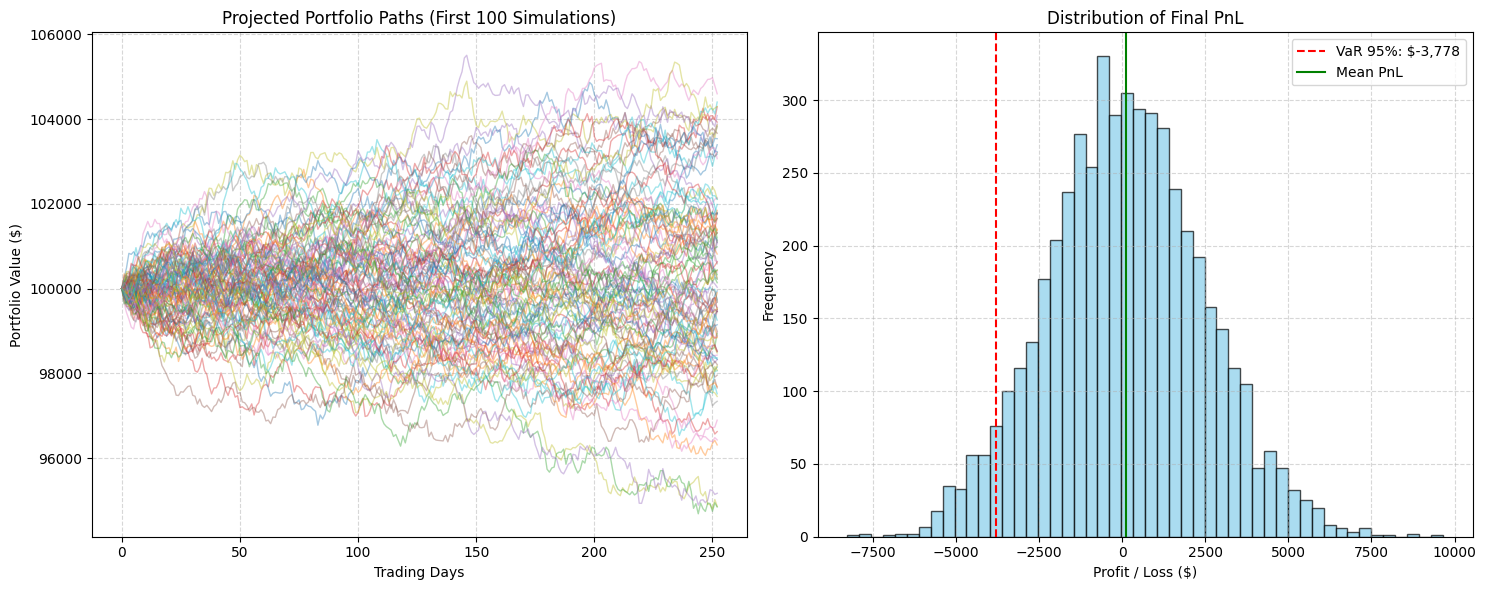

In [5]:
# Generate plots inline
%matplotlib inline

plot_simulation(paths, final_values, INITIAL_PORTFOLIO, metrics)

## 5. Summary & Conclusions

* **Growth Potential:** The portfolio shows a positive expected return on average, but variance is high.
* **Risk Exposure:** The **VaR (95%)** indicates that in 1 out of 20 years, we should expect losses exceeding the calculated threshold.
* **Tail Risk:** The **CVaR** highlights that extreme market events could lead to significantly deeper losses than the standard VaR number suggests.

### Limitations
* **Historical Bias:** This model assumes past volatility and correlations will persist into the future, which may not hold during unprecedented market events.
* **Normality Assumption:** Real financial markets often have "fatter tails" (more frequent extreme crashes) than the normal distribution used in this model.